In [67]:
#import cvxpy as cvx
#import cvxopt
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
import networkx as nx
import numpy as np
import argparse
from typing import Tuple
# %matplotlib inline
import matplotlib.pyplot as plt
import random
import os, sys
import subprocess
import re
import numpy as np
import pickle
import pylab
from time import time
import types
from qiskit import Aer, BasicAer, ClassicalRegister
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import SPSA, COBYLA, L_BFGS_B
from qiskit.aqua.components.variational_forms import RY, RYRZ
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, QubitMappingType, TransformationType

In [52]:
args = types.SimpleNamespace()
args.molecule='H2' 
#args.basis_set='ccpvdz' 
args.basis_set='6311g*' 
#args.algorithm='VQE' 
#args.transformation_type='TransformationType.FULL' 
#args.qubitmapping_type='QubitMappingType.BRAVYI_KITAEV' 
args.qubitmapping_type='bravyi_kitaev'
#args.qubitmapping_type='jordan_wigner'
#args.qubitmapping_type='parity'
#args.two_qubit_reduce = True
#args.vqe_optimizer='SPSA' 
#args.vqe_max_iter=2
#args.vqe_var_form='RY' 
args.vqe_depth=1 
args.vqe_entangler='linear' 
args.num_shots=10
args.max_parallel_threads=10 
#args.vqe_sim = True
#args.vqe_aer = True
#args.datapath='/pylon5/cc5phsp/cbernaci/mol2qpu'
args.outpath_mol='/home/ubuntu/mol2qpu/output/operators/molecule/'
args.outpath_ferm='/home/ubuntu/mol2qpu/output/operators/fermionic/'
args.outpath_qub='/home/ubuntu/mol2qpu/output/operators/qubit/'
args.outpath_vqe='/home/ubuntu/mol2qpu/output/VQE_results/'
#args.random_seed=750 
args.vqe_opt_params = False

In [53]:
molecule = 'H .0 .0 -0.25; H .0 .0 0.25'
driver = PySCFDriver(molecule, basis=args.basis_set)
qmolecule = driver.run()
ferOp = FermionicOperator(h1=qmolecule.one_body_integrals, h2=qmolecule.two_body_integrals) 
qubitOp = ferOp.mapping(map_type='bravyi_kitaev', threshold=0.00000001)
print("num qubits, bravyi_kitaev = ", qubitOp.num_qubits)
print("num_orbitals = ", qmolecule.num_orbitals)
print("num_electrons = ", qmolecule.num_alpha + qmolecule.num_beta)
print("num_modes = ", ferOp.modes)

num qubits, bravyi_kitaev =  12
num_orbitals =  6
num_electrons =  2
num_modes =  12


In [54]:
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(circuit_caching=True, 
                                   backend=backend,
                                   backend_options={'max_parallel_threads': args.max_parallel_threads,                                                                             'max_parallel_experiments': 0, 
                                                    'shots': args.num_shots})
optimizer = SPSA(max_trials=200)
var_form = RY(qubitOp.num_qubits, depth=args.vqe_depth, entanglement=args.vqe_entangler)   
algo = VQE(qubitOp, var_form, optimizer)
#print(type(algo))
#result = algo.run(quantum_instance)  
print(algo.print_settings())


==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.aqua.components.variational_forms.ry.RY object at 0x7f6a61b89b80>
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x7f6a7127d310>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x7f6a7127d0d0>>
-- initial_point: Random seed
-- parameterized_circuits: None
-- use_simulator_snapshot_mode: None
-- ret: None
-- eval_time: None
-- callback: None
-- operator: Representation: paulis, qubits: 12, size: 919
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: True
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]', 'θ[8]', 'θ[9]', 'θ[10]', 'θ[11]', 'θ[12]', 'θ[13]', 'θ[14]', 'θ[15]', 'θ[16]', 'θ[17]', 'θ[18]', 'θ[19]', 'θ[20]', 'θ[21]', 'θ[22]', 'θ[23]']
Variational Form: RY
-- num_parameters: 24
-- num_qubits: 12
-- bounds: [(-3.141592653589793, 3.

In [14]:
### save VQE run results
#filename_vqe = args.outpath_vqe + args.molecule + '_' + args.basis_set + '_' + '0pt5' + '_VQE_SPSA_RY_lin_bk' + '.pkl'
#filehandler_vqe = open(filename_vqe, 'wb')
#pickle.dump(result, filehandler_vqe)

### What is in the `result` object and where can i find all the eigenvectors that were considered?

In [55]:
filename_vqe = args.outpath_vqe + args.molecule + '_' + args.basis_set + '_' + '0pt5' + '_VQE_SPSA_RY_lin_bk' + '.pkl'
print("filename of VQE results = ", filename_vqe)
result_load = pickle.load(open(filename_vqe,'rb'))
result_load
#eigvecs = result_load.get('eigvecs')
#result_load['eigvecs']

filename of VQE results =  /home/ubuntu/mol2qpu/output/VQE_results/H2_6311g*_0pt5_VQE_SPSA_RY_lin_bk.pkl


{'num_optimizer_evals': None,
 'min_val': 2.1882083999015456,
 'opt_params': array([ 3.33730801, -0.59790242,  1.22916622, -1.28588069, -0.35806376,
        -0.22746808, -0.81697804,  2.36872164,  1.73986058,  3.71119014,
        -3.22456415,  2.94237976,  2.51237925, -1.38621581,  0.57315581,
         2.05650363,  0.40671521, -0.99856419, -1.64279571, -2.4659384 ,
         0.14266665,  2.42598658, -3.04330373, -3.53165386]),
 'eval_time': 1184.6517148017883,
 'eval_count': 451,
 'energy': 2.1882083999015456,
 'eigvals': array([2.1882084]),
 'min_vector': {'000100101110': 2,
  '000110001000': 1,
  '001000000000': 1,
  '000100001100': 1,
  '000110001100': 1,
  '000100000000': 2,
  '000100000001': 1,
  '000100100000': 1},
 'eigvecs': array([{'000100101110': 2, '000110001000': 1, '001000000000': 1, '000100001100': 1, '000110001100': 1, '000100000000': 2, '000100000001': 1, '000100100000': 1}],
       dtype=object)}

### function `get_optimal_vector` determines list of eigenvectors returned from running VQE

In [64]:
print(result_load['opt_params'])

print(quantum_instance)
print(dir(quantum_instance))
print(quantum_instance.is_statevector)

[ 3.33730801 -0.59790242  1.22916622 -1.28588069 -0.35806376 -0.22746808
 -0.81697804  2.36872164  1.73986058  3.71119014 -3.22456415  2.94237976
  2.51237925 -1.38621581  0.57315581  2.05650363  0.40671521 -0.99856419
 -1.64279571 -2.4659384   0.14266665  2.42598658 -3.04330373 -3.53165386]

Qiskit Terra version: 0.12.0
Backend: 'qasm_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1024)
{'timeout': None}
{'backend_options': {'max_parallel_threads': 10, 'max_parallel_experiments': 0, 'shots': 10}}
{}
Measurement mitigation: None
['BACKEND_CONFIG', 'BACKEND_OPTIONS', 'BACKEND_OPT

In [97]:
def get_optimal_vector(self, result_load, quantum_instance):
    from qiskit.aqua.utils.run_circuits import find_regs_by_name
    #self._ret['opt_params'] = result_load['opt_params']
    if 'opt_params' not in result_load:
        print("here we are")
        #raise AquaError("Cannot find optimal vector before running the "
        #                     "algorithm to find optimal params.")
    qc = self._var_form.construct_circuit(result_load['opt_params'])
    print(qc)
    #print(qc)
    #qc = self.get_optimal_circuit()
    print("=================")
    if quantum_instance.is_statevector:
        ret = self._quantum_instance.execute(qc)
        self._ret['min_vector'] = ret.get_statevector(qc)
    else:
        c = ClassicalRegister(qc.width(), name='c')
        q = find_regs_by_name(qc, 'q')
        qc.add_register(c)
        qc.barrier(q)
        qc.measure(q, c)
        print(qc)
        ret = quantum_instance.execute(qc)
        #self._ret['min_vector'] = ret.get_counts(qc)
        counts = ret.get_counts(qc)
    return counts

In [98]:
eigvecs = get_optimal_vector(algo, result_load, quantum_instance)

          ┌────────────────┐  ░                                               »
 q_0: |0>─┤ U3(3.3373,0,0) ├──░───────────────■───────────────────────────────»
         ┌┴────────────────┤  ░ ┌──────────┐┌─┴─┐┌──────────┐                 »
 q_1: |0>┤ U3(-0.5979,0,0) ├──░─┤ U2(0,pi) ├┤ X ├┤ U2(0,pi) ├──■──────────────»
         └┬────────────────┤  ░ ├──────────┤└───┘└──────────┘┌─┴─┐┌──────────┐»
 q_2: |0>─┤ U3(1.2292,0,0) ├──░─┤ U2(0,pi) ├─────────────────┤ X ├┤ U2(0,pi) ├»
         ┌┴────────────────┤  ░ ├──────────┤                 └───┘└──────────┘»
 q_3: |0>┤ U3(-1.2859,0,0) ├──░─┤ U2(0,pi) ├──────────────────────────────────»
         ├─────────────────┴┐ ░ ├──────────┤                                  »
 q_4: |0>┤ U3(-0.35806,0,0) ├─░─┤ U2(0,pi) ├──────────────────────────────────»
         ├──────────────────┤ ░ ├──────────┤                                  »
 q_5: |0>┤ U3(-0.22747,0,0) ├─░─┤ U2(0,pi) ├──────────────────────────────────»
         ├──────────────────┤ ░ ├───────

In [91]:
eigvecs
dir(algo)

{'000100100000': 1,
 '000111100000': 1,
 '001000001100': 1,
 '000100000000': 2,
 '000111101110': 2,
 '000100000010': 1,
 '000111000001': 1,
 '000110000000': 1}

['CONFIGURATION',
 'SECTION_KEY_ALGORITHM',
 'SECTION_KEY_DISCRIMINATIVE_NET',
 'SECTION_KEY_EIGS',
 'SECTION_KEY_FEATURE_MAP',
 'SECTION_KEY_GENERATIVE_NETWORK',
 'SECTION_KEY_INITIAL_STATE',
 'SECTION_KEY_IQFT',
 'SECTION_KEY_MULTICLASS_EXT',
 'SECTION_KEY_MULTIVARIATE_DIST',
 'SECTION_KEY_OPTIMIZER',
 'SECTION_KEY_ORACLE',
 'SECTION_KEY_QFT',
 'SECTION_KEY_RECIPROCAL',
 'SECTION_KEY_UNCERTAINTY_PROBLEM',
 'SECTION_KEY_UNIVARIATE_DIST',
 'SECTION_KEY_VAR_FORM',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_auto_conversion',
 '_aux_operators',
 '_callback',
 '_config_the_best_mode',
 '_configuration',
 '_cost_fn'

In [ ]:
circ_opt = algo.get_optimal_circuit()
print(circ_opt)
print('circuit_summary=', quantum_instance.circuit_summary)
print(algo.print_settings())

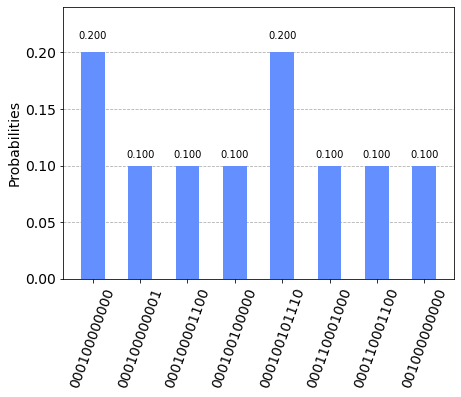

In [19]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(result_load['eigvecs'])